## Оценка качества поиска. Сплиты, асессоры.

In [1]:
import tqdm.notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
c1 = np.loadtxt("c1.txt")
c2 = np.loadtxt("c2.txt")

In [3]:
c1.shape

(1000000, 10)

In [4]:
def get_split(c, num_split):
    idx = np.random.choice(c.shape[0], c.shape[0], replace=True)
    return np.split(c[idx, :], num_split)

In [5]:
def get_ctr(groups):
    session_count = groups[0].shape[0]
    CTR = []
    for i in range(len(groups)):
        zero_session_ct = np.sum(~groups[i].any(1))
        CTR.append((session_count - zero_session_ct) / session_count)
    return CTR

In [6]:
def get_fcr(groups):
    session_count = groups[0].shape[0]
    FCR = []
    for i in range(len(groups)):
        first_clicks = np.sum(groups[i][:, 0])
        FCR.append((session_count - first_clicks) / session_count)
    return FCR

In [7]:
def stat(c1, c2, iters):
    rejects = {}
    rejects['CTR'] = 0
    rejects['FCR'] = 0
    
    metrics = {}
    metrics['CTR'] = []
    metrics['FCR'] = []
    
    for i in tqdm.notebook.tqdm(range(iters)):
        groups1 = get_split(c1, 1000)
        groups2 = get_split(c2, 1000)
        
        ctr1 = get_ctr(groups1)
        ctr2 = get_ctr(groups2)
        metrics['CTR'].append((np.mean(ctr1), np.mean(ctr2)))
        t, _ = stats.ttest_ind(ctr1, ctr2, equal_var=False)
        if abs(t) > 1.96:
            rejects['CTR'] += 1

        fcr1 = get_fcr(groups1)
        fcr2 = get_fcr(groups2)
        metrics['FCR'].append((np.mean(fcr1), np.mean(fcr2)))
        t, _ = stats.ttest_ind(fcr1, fcr2, equal_var=False)
        if abs(t) > 1.96:
            rejects['FCR'] += 1
    return rejects, metrics

In [8]:
rejects, metrics = stat(c1, c2, 1000)

In [11]:
print("CTR rejects:", rejects['CTR'], "---- CRT ASL:", rejects['CTR'] / 1000)
print("FCR rejects:", rejects['FCR'], "---- FCR ASL:", rejects['FCR'] / 1000)

CTR rejects: 1000 ---- CRT ASL: 1.0
FCR rejects: 1000 ---- FCR ASL: 1.0


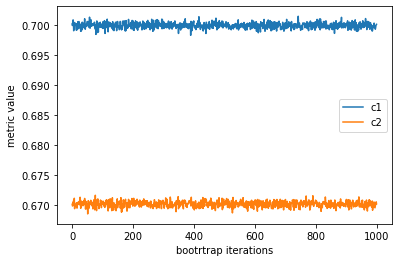

In [14]:
plt.plot(np.array(metrics['CTR'])[:, 0], label='c1')
plt.plot(np.array(metrics['CTR'])[:, 1], label='c2')
plt.xlabel('bootrtrap iterations')
plt.ylabel('metric value')
plt.legend()
plt.show()

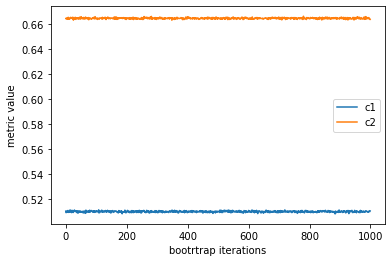

In [15]:
plt.plot(np.array(metrics['FCR'])[:, 0], label='c1')
plt.plot(np.array(metrics['FCR'])[:, 1], label='c2')
plt.xlabel('bootrtrap iterations')
plt.ylabel('metric value')
plt.legend()
plt.show()

### Выводы

* Нулевая гипотеза отвергнута с ASL = 1.0 т.е. различия в сплитах статистически значимы
* По CTR первый сплит оказался лучше
* По FCR (Clicks@1) второй сплит оказался лучше